## Data

In [213]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import *
import time

YEAR = '2021'

# df = pd.read_csv('mlb odds {}.csv'.format(YEAR))#.dropna()
df = pd.read_excel('mlb odds {}.xlsx'.format(YEAR))#.iloc[:-1]
print(len(df))
df['Pitcher'] = df['Pitcher'].str.split('\xa0').str[-1].str.split('-').str[0].str.replace(' ', '')
df['Pitcher'] = df['Team'] + '_' + df['Pitcher']
df['Date'] = df['Date'].astype('int').astype(str)
df

3768


,Date,Rot,VH,Team,Pitcher,1st,2nd,3rd,4th,5th,...,9th,Final,Open,Close,RunLine,Unnamed: 18,OpenOU,Unnamed: 20,CloseOU,Unnamed: 22
0,401,961,V,PIT,PIT_CKUHL,2.0,1.0,0.0,0.0,1.0,...,0,5,183.0,190,1.5,-120.0,7.0,-110.0,6.5,-115.0
1,401,962,H,CUB,CUB_KHENDRICK,1.0,0.0,1.0,0.0,0.0,...,0,3,-205.0,-210,-1.5,100.0,7.0,-110.0,6.5,-105.0
2,401,963,V,ATL,ATL_MFRIED,0.0,0.0,0.0,0.0,0.0,...,0,2,-105.0,117,1.5,-190.0,7.5,-110.0,7.5,100.0
3,401,964,H,PHI,PHI_ANOLA,1.0,0.0,1.0,0.0,0.0,...,0,3,-105.0,-127,-1.5,170.0,7.5,-110.0,7.5,-120.0
4,401,965,V,ARI,ARI_MBUMGARNE,1.0,0.0,0.0,0.0,6.0,...,0,7,188.0,205,1.5,100.0,8.0,-120.0,8.5,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3763,824,1018,H,MIL,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7,NaN,-208,NaN,NaN,NaN,NaN,NaN,NaN
3764,824,1019,V,KAN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0,NaN,216,NaN,NaN,NaN,NaN,NaN,NaN
3765,824,1020,H,HOU,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4,NaN,-256,NaN,NaN,NaN,NaN,NaN,NaN
3766,824,1021,V,LAD,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1,NaN,-143,NaN,NaN,NaN,NaN,NaN,NaN


#### Group Pitchers by Starter (>10% of games) and Relief

In [214]:
pitcher2team = df.groupby('Pitcher')['Team'].last()
g = df.groupby(['Pitcher'])['Close'].count()
numgames = df.groupby('Team')['Close'].count()
fltr = g > (.1 * numgames[pitcher2team[g.index]].values)
df['Pitcher_'] = df['Pitcher'].where(df['Pitcher'].isin(g[fltr].index), df['Team'] + '_Other')
pitcher2team = df.groupby('Pitcher_')['Team'].last()
g[fltr]

Pitcher
ARI_CSMITH       13
ARI_MBUMGARNE    19
ARI_MKELLY       24
ARI_ZGALLEN      16
ATL_CMORTON      25
                 ..
WAS_EFEDDE       20
WAS_JLESTER      16
WAS_JROSS        18
WAS_MSCHERZER    19
WAS_PCORBIN      24
Name: Close, Length: 142, dtype: int64

#### Condense original data to 1 row per game

In [215]:
odds2prob = lambda s: np.where(s>0, 100/(s+100), s/(s-100))
logit = lambda s: 0.25*np.log(s/(1-s))
logistic = lambda s: 1/(1+np.exp(-4*s))

ndf = pd.DataFrame()
even = df.iloc[::2].reset_index(drop=True)
odd = df.iloc[1::2].reset_index(drop=True)
ndf['Date'] = pd.to_datetime(YEAR + even['Date'].astype(str).str.zfill(4))
ndf['V'] = even['Team']
ndf['H'] = odd['Team']
ndf['VP'] = even['Pitcher_']
ndf['HP'] = odd['Pitcher_']
ndf['ML'] = (odds2prob(even['Close']) + 1-odds2prob(odd['Close']))/2
ndf['LogitML'] = logit(ndf['ML'])
ndf['VF'] = even['Final']
ndf['HF'] = odd['Final']
ndf['W'] = ndf['V'].where(ndf['VF'] > ndf['HF'], ndf['H'])
ndf['L'] = ndf['V'].where(ndf['VF'] < ndf['HF'], ndf['H'])

ndf

,Date,V,H,VP,HP,ML,LogitML,VF,HF,W,L
0,2021-04-01,PIT,CUB,PIT_CKUHL,CUB_KHENDRICK,0.333704,-0.172870,5,3,PIT,CUB
1,2021-04-01,ATL,PHI,ATL_MFRIED,PHI_ANOLA,0.450679,-0.049482,2,3,PHI,ATL
2,2021-04-01,ARI,SDG,ARI_MBUMGARNE,SDG_YDARVISH,0.315450,-0.193691,7,8,SDG,ARI
3,2021-04-01,LAD,COL,LAD_CKERSHAW,COL_GMARQUEZ,0.671778,0.179060,5,8,COL,LAD
4,2021-04-01,STL,CIN,STL_JFLAHERTY,CIN_LCASTILLO,0.461074,-0.039005,11,6,STL,CIN
...,...,...,...,...,...,...,...,...,...,...,...
1879,2021-08-24,NYY,ATL,NYY_Other,ATL_Other,0.433713,-0.066679,5,4,NYY,ATL
1880,2021-08-24,DET,STL,DET_Other,STL_Other,0.314596,-0.194680,4,3,DET,STL
1881,2021-08-24,CIN,MIL,CIN_Other,MIL_Other,0.342843,-0.162662,4,7,MIL,CIN
1882,2021-08-24,KAN,HOU,KAN_Other,HOU_Other,0.298677,-0.213401,0,4,HOU,KAN


#### Check for anomalies

In [216]:
teams = pd.get_dummies(ndf['V'], dtype=int).sub(pd.get_dummies(ndf['H'], dtype=int), fill_value=0).astype(int)
assert (teams.sum(axis=1)==0).all()
assert (teams.abs().sum(axis=1)==2).all()

pitchers = pd.get_dummies(ndf['VP'], dtype=int).sub(pd.get_dummies(ndf['HP'], dtype=int), fill_value=0).astype(int)
assert (pitchers.sum(axis=1)==0).all()
# assert (pitchers.abs().sum(axis=1)==2).all()
ndf.loc[pitchers.abs().sum(axis=1)!=2]

,Date,V,H,VP,HP,ML,LogitML,VF,HF,W,L


## Strength Model

In [217]:
HALFLIFE = 14

today = pd.Timestamp(pd.Timestamp.today().date())
days = (today - ndf['Date'])

temp = ndf.loc[~ndf['ML'].isnull()]
temp['Weight'] = 2**(-(days/HALFLIFE)/pd.to_timedelta(1, unit='D'))

Y = temp['LogitML']
X = sm.add_constant(pd.concat([teams, pitchers], axis=1)).loc[~ndf['ML'].isnull()]
W = temp['Weight']
fit = sm.WLS(Y, X, W).fit()
print('resid stdv:', fit.resid.std())
fit.summary()

resid stdv: 0.05429394954239495


<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                LogitML   R-squared:                       0.935
Model:                            WLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     143.7
Date:                Tue, 24 Aug 2021   Prob (F-statistic):               0.00
Time:                        23:57:18   Log-Likelihood:                 2315.8
No. Observations:                1884   AIC:                            -4288.
Df Residuals:                    1712   BIC:                            -3334.
Df Model:                         171                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0391      0.001    -48.158      0.000      -0.041      -0.038
ARI              -0.0850      0.003    -26.903      0.000      -0.091      -0.079
ATL               0.0456      0.004     12.073      0.000       0.038       0.053
BAL              -0.1011      0.003    -36.513      0.000      -0.107      -0.096
BOS               0.0384      0.003     12.642      0.000       0.032       0.044
CIN               0.0108      0.003      3.553      0.000       0.005       0.017
CLE              -0.0236      0.007     -3.454      0.001      -0.037      -0.010
COL              -0.0488      0.003    -15.358      0.000      -0.055      -0.043
CUB              -0.0622      0.003    -21.391      0.000      -0.068      -0.057
CWS               0.0653      0.003     23.063      0.000       0.060       0.071
DET              -0.0805      0.007    -11.547      0.000      -0.094      -0.067
HOU               0.0727      0.004     17.754      0.000       0.065       0.081
KAN              -0.0603      0.003    -20.866      0.000      -0.066      -0.055
LAA              -0.0189      0.004     -4.207      0.000      -0.028      -0.010
LAD               0.1190      0.006     20.611      0.000       0.108       0.130
MIA              -0.0250      0.005     -5.271      0.000      -0.034      -0.016
MIL               0.0693      0.003     22.587      0.000       0.063       0.075
MIN              -0.0208      0.004     -5.935      0.000      -0.028      -0.014
NYM               0.0389      0.005      7.111      0.000       0.028       0.050
NYY               0.0540      0.003     16.117      0.000       0.047       0.061
OAK               0.0323      0.003     11.368      0.000       0.027       0.038
PHI               0.0190      0.004      4.765      0.000       0.011       0.027
PIT              -0.0941      0.004    -25.006      0.000      -0.102      -0.087
SDG               0.0622      0.003     19.472      0.000       0.056       0.068
SEA              -0.0370      0.004     -9.166      0.000      -0.045      -0.029
SFO               0.0580      0.003     19.937      0.000       0.052       0.064
STL              -0.0164      0.005     -3.127      0.002      -0.027      -0.006
TAM               0.0589      0.006      9.751      0.000       0.047       0.071
TEX              -0.1003      0.003    -29.343      0.000      -0.107      -0.094
TOR               0.0606      0.003     20.971      0.000       0.055       0.066
WAS              -0.0310      0.004     -8.434      0.000      -0.038      -0.024
ARI_CSMITH       -0.0265      0.009     -2.888      0.004      -0.045      -0.009
ARI_MBUMGARNE    -0.0203      0.008     -2.684      0.007      -0.035      -0.005
ARI_MKELLY        0.0016      0.008      0.208      0.836      -0.014       0.017
ARI_Other        -0.0340      0.005     -6.864   

### Team Strength

In [218]:
tdf = fit.params.loc[df['Team'].unique()]
tdf.sort_values(ascending=False)

LAD    0.118985
HOU    0.072743
MIL    0.069329
CWS    0.065270
SDG    0.062157
TOR    0.060593
TAM    0.058883
SFO    0.058029
NYY    0.054050
ATL    0.045629
NYM    0.038890
BOS    0.038368
OAK    0.032260
PHI    0.019010
CIN    0.010793
STL   -0.016387
LAA   -0.018886
MIN   -0.020800
CLE   -0.023552
MIA   -0.025037
WAS   -0.030998
SEA   -0.037035
COL   -0.048766
KAN   -0.060279
CUB   -0.062204
DET   -0.080481
ARI   -0.085004
PIT   -0.094147
TEX   -0.100289
BAL   -0.101125
dtype: float64

### Pitcher Strength

In [219]:
p = fit.params.loc[sorted(df['Pitcher_'].unique())]
g = df.groupby('Pitcher_')['Team'].count()[p.index]
pdf = pd.DataFrame({'T': pitcher2team[p.index], 
                    'P': p.index,
                    'Beta': p.values, 
                    'Count': g.values})
pdf['Sum'] = pdf['Beta'] * pdf['Count']
pdf.sort_values('Beta', ascending=False)#.sort_index(level=0, sort_remaining=False)
# pdf.groupby('T')['Sum'].sum() / pdf.groupby('T')['Count'].sum()

,T,P,Beta,Count,Sum
NYM_JDEGROM,NYM,NYM_JDEGROM,0.147026,15,2.205396
CLE_SBIEBER,CLE,CLE_SBIEBER,0.137039,14,1.918542
WAS_MSCHERZER,WAS,WAS_MSCHERZER,0.098512,19,1.871734
NYY_GCOLE,NYY,NYY_GCOLE,0.089340,23,2.054829
MIL_BWOODRUFF,MIL,MIL_BWOODRUFF,0.082799,24,1.987168
...,...,...,...,...,...
SEA_JSHEFFIEL,SEA,SEA_JSHEFFIEL,-0.065799,15,-0.986990
LAA_DBUNDY,LAA,LAA_DBUNDY,-0.067642,18,-1.217564
MIA_Other,MIA,MIA_Other,-0.069623,61,-4.246974
CIN_Other,CIN,CIN_Other,-0.072509,17,-1.232648


## Schedule

In [220]:
teammap

Ana         LAA
Bal         BAL
Bos         BOS
ChW         CWS
Cle         CLE
          ...  
@Sfo-2    @SFO2
@StL-2    @STL2
@Was-2    @WAS2
pp          NaN
NaN         NaN
Name: Team, Length: 122, dtype: object

In [221]:
teammap = pd.read_excel('MLB_schedule_2021.xlsx', 'map', index_col=0)['Team']
teammap['pp'] = np.nan
teammap[np.nan] = np.nan
sched = pd.read_excel('MLB_schedule_2021.xlsx', 'Sheet1', index_col=0)
sched.index = pd.to_datetime(YEAR + '/' + sched.index)

sched.columns = teammap[sched.columns]
for col in sched.columns:
    sched[col] = teammap[sched[col]].values

# make sure everyone has a full schedule
assert ((~sched.isna()).sum() + (sched.apply(lambda c: c.str[-1]=='2', axis=1)).sum() == 162).all()

In [222]:
sched

Team,LAA,BAL,BOS,CWS,CLE,DET,HOU,KAN,MIN,NYY,...,MIA,LAD,MIL,NYM,PHI,PIT,SDG,SFO,STL,WAS
Date,,,,,,,,,,,,,,,,,,,,,
2021-04-01,CWS,NaN,NaN,@LAA,@DET,CLE,@OAK,TEX,@MIL,TOR,...,TAM,@COL,MIN,NaN,ATL,@CUB,ARI,@SEA,@CIN,NaN
2021-04-02,CWS,@BOS,BAL,@LAA,NaN,NaN,@OAK,NaN,NaN,NaN,...,TAM,@COL,NaN,NaN,NaN,NaN,ARI,@SEA,NaN,NaN
2021-04-03,CWS,@BOS,BAL,@LAA,@DET,CLE,@OAK,TEX,@MIL,TOR,...,TAM,@COL,MIN,NaN,ATL,@CUB,ARI,@SEA,@CIN,NaN
2021-04-04,CWS,@BOS,BAL,@LAA,@DET,CLE,@OAK,TEX,@MIL,TOR,...,NaN,@COL,MIN,NaN,ATL,@CUB,ARI,NaN,@CIN,NaN
2021-04-05,HOU,@NYY,TAM,@SEA,KAN,MIN,@LAA,@CLE,@DET,BAL,...,STL,@OAK,@CUB,@PHI,NYM,@CIN,SFO,@SDG,@MIA,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-29,@TEX,BOS,@BAL,CIN,@KAN,@MIN,TAM,CLE,DET,@TOR,...,@NYM,SDG,@STL,MIA,@ATL,CUB,@LAD,ARI,MIL,@COL
2021-09-30,@TEX,BOS,@BAL,NaN,@KAN,@MIN,TAM,CLE,DET,@TOR,...,@NYM,SDG,@STL,MIA,@ATL,CUB,@LAD,ARI,MIL,NaN
2021-10-01,@SEA,@TOR,@WAS,DET,@TEX,@CWS,OAK,MIN,@KAN,TAM,...,PHI,MIL,@LAD,@ATL,@MIA,CIN,@SFO,SDG,CUB,BOS


#### Future Games

In [223]:
fut = pd.DataFrame()
nplayed = ndf.groupby('V')['H'].count() + ndf.groupby('H')['V'].count()
print('# Home games:')

for home in sched.columns:
    g = sched[home].dropna().reset_index()
    g.columns = ['Date', 'V']
    doubles = []
    for i, row in g[g['V'].str[-1]=='2'].iterrows():
        x = [g['Date'][i], g['V'][i][:-1]]
        g.iloc[i] = x
        doubles.append(x)
    doubles = pd.DataFrame(doubles, columns=g.columns)
    g = g.append(doubles).sort_values('Date').reset_index(drop=True)
    g['H'] = home
    assert len(g)==162
    g = g.loc[g['V'].str[0]!='@']
    
    count = ndf.loc[ndf['H']==home].groupby('V')['VF'].count()
    g = pd.concat([g.loc[g['V']==away].iloc[count.get(away, 0):] for away in g['V'].unique()])
    fut = fut.append(g)
    print(home, count.sum() + len(g))

# Home games:
LAA 82
BAL 81
BOS 81
CWS 81
CLE 81
DET 81
HOU 81
KAN 81
MIN 81
NYY 81
OAK 81
SEA 81
TAM 81
TEX 81
TOR 81
ARI 81
ATL 81
CUB 81
CIN 81
COL 81
MIA 81
LAD 81
MIL 81
NYM 81
PHI 81
PIT 81
SDG 81
SFO 81
STL 81
WAS 81


In [224]:
adf = pd.concat([ndf, fut.sort_values('Date')], axis=0, sort=False)
print(adf.groupby('V')['Date'].count() + adf.groupby('H')['Date'].count() > 162)
assert (adf.groupby('V')['Date'].count() + adf.groupby('H')['Date'].count() == 162).all()

V
ARI    False
ATL    False
BAL    False
BOS    False
CIN    False
CLE    False
COL    False
CUB    False
CWS    False
DET    False
HOU    False
KAN    False
LAA     True
LAD    False
MIA    False
MIL    False
MIN    False
NYM    False
NYY    False
OAK    False
PHI    False
PIT    False
SDG    False
SEA    False
SFO    False
STL    False
TAM    False
TEX    False
TOR     True
WAS    False
Name: Date, dtype: bool


AssertionError: 

#### MANUALLY REMOVE DUPLICATE GAMES

In [225]:
fut.loc[(fut['V']=='TOR')&(fut['H']=='LAA')]

,Date,V,H
115,2021-08-12,TOR,LAA


In [226]:
# MANUALLY REMOVE DUPLICATE GAMES
fut = fut.loc[~((fut['V']=='TOR')&(fut['H']=='LAA'))]
adf = pd.concat([ndf, fut.sort_values('Date')], axis=0, sort=False)
assert (adf.groupby('V')['Date'].count() + adf.groupby('H')['Date'].count() == 162).all()

- Set of pitchers who have not pitched in last 4 days
- Choose randomly from pitchers who have not played in last 4 days weighted by .2 + beta, and bullpen weighted by .1 + beta

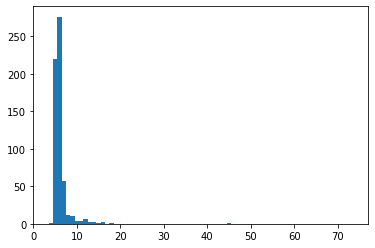

4       1
5     220
6     276
7      57
8      12
9      10
10      4
11      4
12      6
13      3
14      2
15      1
16      2
18      1
45      1
74      1
dtype: int64

In [227]:
ptop = pdf.sort_values('Beta').groupby('T').last()\
                .reset_index().set_index('P')[['T', 'Beta', 'Count']]
ptop

dates = []
for p in ptop.index:
    d = ndf.loc[(ndf['VP']==p)|(ndf['HP']==p), 'Date']
    dates += (d - d.shift()).dt.days.dropna().astype(int).to_list()
dates = pd.Series(dates)
plt.hist(dates, bins=np.arange(min(dates)-.5, max(dates)+.5))
plt.show()
dates.groupby(dates).count()#/len(dates)

In [228]:
start = fut.loc[fut['Date'] >= ndf['Date'].max(), 'Date'].min()
end = fut['Date'].max()
fut.loc[fut['Date'] < start, 'Date'] = end
fut = fut.sort_values('Date').reset_index(drop=True)
print((start, end))

def random_choice_prob_index(a, axis=1):
    r = np.expand_dims(np.random.rand(a.shape[1-axis]), axis=axis)
    return (a.cumsum(axis=axis) > r).argmax(axis=axis)

def rand_team_schedule(team, n):
    STR_MULT = 20
    RELIEF_HANDICAP = .03
    OUT_5_PROB = .45
    
    # calc pitcher weights
    p = pdf.loc[pdf['T'] == team]
    p['Weight'] = np.where(p['P'].str[-2:]=='er', 
                           logistic((p['Beta'] - RELIEF_HANDICAP) * STR_MULT), 
                           logistic(p['Beta'] * STR_MULT))
    
    # get past pitcher schedule
    t = ndf.loc[ndf['V']==team][['Date', 'VP']]
    t.columns = ['Date', 'HP']
    t = t.append(ndf.loc[ndf['H']==team][['Date', 'HP']]).sort_values('Date')
    t.columns = ['Date', 'P']
    g = pd.concat([t.groupby('P')['Date'].last()] * n, axis=1)
    g.columns = range(n)
    
    weights = pd.concat([p['Weight']] * n, axis=1)
    weights.columns = range(n)
    
    d_pitchers = {}
    d_strengths = {}
    
    temp = fut.loc[(fut['H']==team) | (fut['V']==team), 'Date']
    
    A = 0
    
    for i in range(len(temp)):
        dt = temp.iloc[i]
        w = (dt - g < timedelta(days=5)) 
        a = time.time()
        if temp.iloc[(i+1)%len(temp)] - dt < timedelta(days=2):
            w |= (dt - g == timedelta(days=5)) & \
                 np.random.binomial(1, OUT_5_PROB, n).astype(bool)
        A += time.time() - a
            
        w.loc[team+'_Other'] = False
        w = weights.mask(w, 0)
        w = w/w.sum()
        r = random_choice_prob_index(w.values, 0)
        g.values[r, np.arange(n)] = dt
        d_pitchers[i] = w.iloc[r, 0].index
        d_strengths[i] = p.loc[d_pitchers[i], 'Beta'].values
    d_pitchers = pd.DataFrame(d_pitchers).T
    d_pitchers.columns = range(n)
    d_strengths = pd.DataFrame(d_strengths).T
    d_strengths.columns = range(n)
    
    return d_pitchers, d_strengths

# dates = []
# a = time.time()
# for team in teams.columns:
#     d_p, d_s = rand_team_schedule(team, 1)
#     temp = fut.loc[(fut['H']==team) | (fut['V']==team), 'Date']
#     d = pd.Series(temp.loc[(d_p == ptop.loc[ptop['T']==team].index).loc[:,0].values])
#     dates += (d - d.shift()).dt.days.dropna().astype(int).to_list()
# print time.time() - a


# dates = pd.Series(dates)
# plt.hist(dates, bins=np.arange(min(dates)-.5, max(dates)+.5))
# plt.show()
# dates.groupby(dates).count()/len(dates)


(Timestamp('2021-08-24 00:00:00'), Timestamp('2021-10-03 00:00:00'))


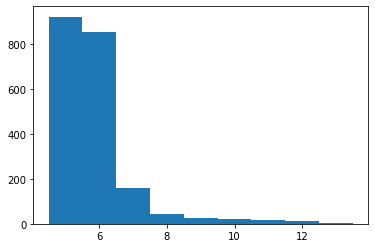

5     0.442733
6     0.409047
7     0.076035
8     0.021655
9     0.011550
10    0.009625
11    0.009143
12    0.005775
13    0.001444
14    0.001444
15    0.000481
16    0.000962
17    0.001444
18    0.001444
19    0.000962
22    0.000481
23    0.000962
25    0.000481
26    0.000481
30    0.000962
35    0.000481
37    0.000481
41    0.000962
46    0.000481
71    0.000481
dtype: float64

In [229]:
days = [5]*920 + [6]*850 + [7]*158 + [8]*45 + [9]*24 + [10]*20 + [11]*19 + [12]*12 + \
    [13, 13, 13, 14, 14, 14, 15, 16, 16, 17, 17, 17, 18, 18, 18, 
     19, 19, 22, 23, 23, 25, 26, 30, 30, 35, 37, 41, 41, 46, 71]
days = pd.Series(days)
plt.hist(days, bins=np.arange(min(days)-.5, 14.5))
plt.show()
days.groupby(days).count()/len(days)

### Get N random pitcher schedules

In [232]:
N = 100

pw = {}
a = time.time()
for team in teams.columns:
    d_p, d_s = rand_team_schedule(team, N)
    pw[team] = d_s
print(time.time() - a)
pw

<ipython-input-228-ba4708ab3ec6>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p['Weight'] = np.where(p['P'].str[-2:]=='er',


3.528996229171753


{'ARI':           0         1         2         3         4         5         6   \
 0   0.001622  0.001622 -0.026525  0.001622 -0.020273  0.001622 -0.020273   
 1  -0.026525 -0.005850 -0.020273 -0.005850  0.001622 -0.026525  0.001622   
 2  -0.005850 -0.020273 -0.005850 -0.020273 -0.026525 -0.005850 -0.005850   
 3  -0.020273 -0.033979  0.001622 -0.026525 -0.005850 -0.020273 -0.026525   
 4  -0.033979 -0.026525 -0.033979 -0.033979 -0.033979 -0.033979 -0.033979   
 5   0.001622 -0.033979 -0.033979  0.001622 -0.020273 -0.033979 -0.020273   
 6  -0.033979  0.001622 -0.026525 -0.005850  0.001622  0.001622 -0.033979   
 7  -0.005850 -0.005850 -0.020273 -0.020273 -0.026525 -0.005850 -0.005850   
 8  -0.020273 -0.020273  0.001622 -0.026525 -0.005850 -0.026525  0.001622   
 9   0.001622 -0.026525 -0.005850  0.001622 -0.020273 -0.020273 -0.026525   
 10 -0.026525  0.001622 -0.026525 -0.005850  0.001622  0.001622 -0.020273   
 11 -0.005850 -0.005850 -0.020273 -0.020273 -0.026525 -0.005850 -0.00

In [233]:
print(len(fut), sum([len(pw[team]) for team in teams.columns])/2)
for team in teams.columns:
    print(team, pw[team].shape[0] == fut.loc[(fut['V']==team)|(fut['H']==team)].shape[0])

546 546.0
ARI True
ATL True
BAL True
BOS True
CIN True
CLE True
COL True
CUB True
CWS True
DET True
HOU True
KAN True
LAA True
LAD True
MIA True
MIL True
MIN True
NYM True
NYY True
OAK True
PHI True
PIT True
SDG True
SEA True
SFO True
STL True
TAM True
TEX True
TOR True
WAS True


In [234]:
pdf.loc[pdf['T']=='BOS']

,T,P,Beta,Count,Sum
BOS_ERODRIGUE,BOS,BOS_ERODRIGUE,0.039125,24,0.938988
BOS_GRICHARDS,BOS,BOS_GRICHARDS,-0.057564,22,-1.266415
BOS_MPEREZ,BOS,BOS_MPEREZ,-0.012419,22,-0.273218
BOS_NEOVALDI,BOS,BOS_NEOVALDI,0.032227,24,0.773447
BOS_NPIVETTA,BOS,BOS_NPIVETTA,0.004365,24,0.104764
BOS_Other,BOS,BOS_Other,0.032635,11,0.358980


In [235]:
ndf.loc[(ndf['V']=='BOS')|(ndf['H']=='BOS')].iloc[-20:]

,Date,V,H,VP,HP,ML,LogitML,VF,HF,W,L
1598,2021-08-03,BOS,DET,BOS_GRICHARDS,DET_Other,0.576081,0.076676,2,4,DET,BOS
1613,2021-08-04,BOS,DET,BOS_ERODRIGUE,DET_CMIZE,0.583152,0.083932,4,1,BOS,DET
1625,2021-08-05,BOS,DET,BOS_MPEREZ,DET_TSKUBAL,0.543141,0.043248,1,8,DET,BOS
1639,2021-08-06,BOS,TOR,BOS_NEOVALDI,TOR_Other,0.420354,-0.080331,4,12,TOR,BOS
1653,2021-08-07,BOS,TOR,BOS_NPIVETTA,TOR_RRAY,0.360624,-0.143164,0,1,TOR,BOS
1656,2021-08-07,BOS,TOR,BOS_Other,TOR_Other,0.393853,-0.107786,2,1,BOS,TOR
1670,2021-08-08,BOS,TOR,BOS_GRICHARDS,TOR_HRYU,0.367251,-0.136007,8,9,TOR,BOS
1689,2021-08-10,TAM,BOS,TAM_Other,BOS_ERODRIGUE,0.461074,-0.039005,8,4,TAM,BOS
1707,2021-08-11,TAM,BOS,TAM_Other,BOS_NEOVALDI,0.481047,-0.018962,8,20,BOS,TAM
1720,2021-08-12,TAM,BOS,TAM_Other,BOS_Other,0.469742,-0.030295,8,1,TAM,BOS


### Get M random game outcomes for each pitcher schedule

In [237]:
M = 100
HOME_ADV = np.random.normal(.04, .005, N*M)
NOISE = np.random.normal(0, .035, (len(fut), N*M))
fut = fut[['Date', 'V', 'H']]
fut['TW'] = tdf[fut['V']].values - tdf[fut['H']].values

fut = pd.concat([fut, pd.DataFrame(0, fut.index, range(100))], axis=1)
sim = pd.DataFrame(index=fut.index)

a=time.time()
for team in teams.columns:
    ft = fut.loc[(fut['V']==team)|(fut['H']==team), 'V'] == team
    vh = np.where(ft, 1, -1)
    fut.loc[ft.index, range(N)] += pw[team].mul(vh, axis=0).values
b=time.time()

sim = pd.concat([fut[range(N)]]*M, axis=1)
sim.columns = range(N*M)
c=time.time()

sim = sim.add(fut['TW'], axis=0)
sim = sim.sub(HOME_ADV, axis=1)
sim.loc[:,:] = np.random.binomial(1, logistic(sim + NOISE))
sim = pd.concat([fut[['Date', 'V', 'H']], sim], axis=1)

d=time.time()

print(b-a, c-b, d-c)
sim.describe()


0.7954139709472656 0.01925206184387207 3.812647819519043


,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
count,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,...,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000,546.000000
mean,0.459707,0.474359,0.487179,0.448718,0.463370,0.463370,0.500000,0.435897,0.445055,0.483516,...,0.479853,0.483516,0.456044,0.476190,0.479853,0.467033,0.448718,0.457875,0.465201,0.459707
std,0.498831,0.499800,0.500294,0.497819,0.499114,0.499114,0.500459,0.496329,0.497428,0.500186,...,0.500052,0.500186,0.498521,0.499891,0.500052,0.499369,0.497819,0.498679,0.499245,0.498831
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [238]:
tdf.sort_values(ascending=False)

LAD    0.118985
HOU    0.072743
MIL    0.069329
CWS    0.065270
SDG    0.062157
TOR    0.060593
TAM    0.058883
SFO    0.058029
NYY    0.054050
ATL    0.045629
NYM    0.038890
BOS    0.038368
OAK    0.032260
PHI    0.019010
CIN    0.010793
STL   -0.016387
LAA   -0.018886
MIN   -0.020800
CLE   -0.023552
MIA   -0.025037
WAS   -0.030998
SEA   -0.037035
COL   -0.048766
KAN   -0.060279
CUB   -0.062204
DET   -0.080481
ARI   -0.085004
PIT   -0.094147
TEX   -0.100289
BAL   -0.101125
dtype: float64

In [239]:
tot = pd.concat([
    pd.concat([
        ndf[['Date', 'V', 'H']], 
        pd.DataFrame({i: 1*(ndf['W']==ndf['V']) for i in range(N*M)})], axis=1), 
    sim]).reset_index(drop=True)
tot

,Date,V,H,0,1,2,3,4,5,6,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,2021-04-01,PIT,CUB,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,2021-04-01,ATL,PHI,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-04-01,ARI,SDG,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-04-01,LAD,COL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-04-01,STL,CIN,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2425,2021-10-03,OAK,HOU,0,0,0,0,1,0,0,...,0,1,1,0,1,1,0,0,1,0
2426,2021-10-03,SDG,SFO,0,1,1,0,0,0,0,...,1,1,1,1,0,1,0,0,1,0
2427,2021-10-03,CUB,STL,1,0,1,0,0,0,0,...,1,1,0,1,0,1,1,0,1,0
2428,2021-10-03,DET,CWS,0,1,0,1,0,0,0,...,1,1,0,0,0,0,1,1,0,0


In [240]:
rec = tot.groupby('V').sum() + tot.groupby('H')[list(range(N*M))].apply(lambda x: (1-x).sum())
rec.T.describe().T.sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
V,,,,,,,,
LAD,10000.0,101.5023,2.887530,91.0,100.0,102.0,103.0,111.0
SFO,10000.0,100.8715,2.988023,90.0,99.0,101.0,103.0,111.0
TAM,10000.0,98.2603,2.919246,87.0,96.0,98.0,100.0,109.0
MIL,10000.0,97.7428,2.921832,86.0,96.0,98.0,100.0,110.0
HOU,10000.0,95.6142,2.889878,84.0,94.0,96.0,98.0,106.0
CWS,10000.0,94.9783,2.904871,83.0,93.0,95.0,97.0,105.0
NYY,10000.0,93.9910,2.909221,83.0,92.0,94.0,96.0,105.0
BOS,10000.0,91.5816,2.921608,81.0,90.0,92.0,94.0,103.0
CIN,10000.0,89.7928,2.935359,76.0,88.0,90.0,92.0,99.0


In [241]:
ngames = tot.groupby(['V', 'H'])[list(range(N*M))].count() + tot.groupby(['H', 'V'])[list(range(N*M))].count().values
h2h = tot.groupby(['V', 'H']).sum() + tot.groupby(['H', 'V'])[list(range(N*M))].apply(lambda x: (1-x).sum()).values
h2h.index.names = ['T1', 'T2']
h2h_wl = (h2h / ngames.values)#.reset_index()
h2h_wl

0         1         2         3         4         5         6     \
T1  T2                                                                          
ARI ATL  0.428571  0.428571  0.428571  0.571429  0.428571  0.714286  0.571429   
    CIN  0.666667  0.666667  0.666667  0.666667  0.666667  0.666667  0.666667   
    COL  0.421053  0.421053  0.473684  0.368421  0.421053  0.526316  0.421053   
    CUB  0.333333  0.333333  0.333333  0.333333  0.333333  0.333333  0.333333   
    HOU  0.166667  0.166667  0.000000  0.000000  0.333333  0.000000  0.000000   
...           ...       ...       ...       ...       ...       ...       ...   
WAS SDG  0.428571  0.428571  0.428571  0.428571  0.428571  0.428571  0.428571   
    SFO  0.285714  0.285714  0.285714  0.285714  0.285714  0.285714  0.285714   
    STL  0.666667  0.666667  0.666667  0.666667  0.666667  0.666667  0.666667   
    TAM  0.750000  0.750000  0.750000  0.750000  0.750000  0.750000  0.750000   
    TOR  0.750000  0.750000  0.750000  0.750000  0.750000  0.750000  0.750000   

             7         8         9     ...      9990      9991      9992  \
T1  T2                                 ...                                 
ARI ATL  0.428571  0.428571  0.571429  ...  0.571429  0.571429  0.571429   
    CIN  0.666667  0.666667  0.666667  ...  0.666667  0.666667  0.666667   
    COL  0.421053  0.368421  0.421053  ...  0.421053  0.421053  0.526316   
    CUB  0.333333  0.333333  0.333333  ...  0.333333  0.333333  0.333333   
    HOU  0.166667  0.000000  0.166667  ...  0.166667  0.166667  0.166667   
...           ...       ...       ...  ...       ...       ...       ...   
WAS SDG  0.428571  0.428571  0.428571  ...  0.428571  0.428571  0.428571   
    SFO  0.285714  0.285714  0.285714  ...  0.285714  0.285714  0.285714   
    STL  0.666667  0.666667  0.666667  ...  0.666667  0.666667  0.666667   
    TAM  0.750000  0.750000  0.750000  ...  0.750000  0.750000  0.750000   
    TOR  0.750000  0.750000  0.750000  ...  0.750000  0.750000  0.750000   

             9993      9994      9995      9996      9997      9998      9999  
T1  T2                                                                         
ARI ATL  0.428571  0.428571  0.428571  0.428571  0.571429  0.714286  0.428571  
    CIN  0.666667  0.666667  0.666667  0.666667  0.666667  0.666667  0.666667  
    COL  0.421053  0.368421  0.526316  0.421053  0.421053  0.421053  0.473684  
    CUB  0.333333  0.333333  0.333333  0.333333  0.333333  0.333333  0.333333  
    HOU  0.166667  0.166667  0.166667  0.166667  0.500000  0.000000  0.166667  
...           ...       ...       ...       ...       ...       ...       ...  
WAS SDG  0.428571  0.428571  0.428571  0.428571  0.428571  0.428571  0.428571  
    SFO  0.285714  0.285714  0.285714  0.285714  0.285714  0.285714  0.285714  
    STL  0.666667  0.666667  0.666667  0.666667  0.666667  0.666667  0.666667  
    TAM  0.750000  0.750000  0.750000  0.750000  0.750000  0.750000  0.750000  
    TOR  0.750000  0.750000  0.750000  0.750000  0.750000  0.750000  0.750000  

[540 rows x 10000 columns]

In [242]:
((rec.sum() == 2430) & (h2h.sum() == 2430)).sum() # == N*M

10000

In [243]:
(h2h_wl.loc['ARI', 'ATL'] + h2h_wl.loc['ATL', 'ARI']).sum() # == N*M

10000.0

In [244]:
divs = {
    'AL_EAST': ['BOS', 'TAM', 'TOR', 'NYY', 'BAL'],
    'AL_CENT': ['CWS', 'CLE', 'DET', 'MIN', 'KAN'],
    'AL_WEST': ['HOU', 'OAK', 'SEA', 'LAA', 'TEX'],
    'NL_EAST': ['NYM', 'WAS', 'ATL', 'PHI', 'MIA'],
    'NL_CENT': ['MIL', 'CUB', 'STL', 'CIN', 'PIT'],
    'NL_WEST': ['SFO', 'LAD', 'SDG', 'COL', 'ARI']
}
AL = ['AL_EAST', 'AL_CENT', 'AL_WEST']
NL = ['NL_EAST', 'NL_CENT', 'NL_WEST']

In [245]:
divwinner = pd.DataFrame(columns=list(range(N*M)))

for div in divs:
    d = divs[div]
    print()
    print(div, ':', d)
    topdiv = rec.loc[d] == rec.loc[d].max()
    topdiv

    divwin = pd.Series(0, index=rec.columns)


    ''' No Tiebreaks '''

    divwin[topdiv.sum()==1] = rec.loc[d].idxmax()[topdiv.sum()==1]


    ''' 2-Way Ties '''

    print('2-way ties:', (topdiv.sum()==2).sum())
    
    # Head-to-Head Record #
    tie = pd.concat([topdiv.loc[:,topdiv.sum()==2].sort_index().idxmax(),
                     topdiv.loc[:,topdiv.sum()==2].sort_index(ascending=False).idxmax()], axis=1)
    tb1 = h2h_wl.loc[[tuple(i) for i in tie.values.tolist()], tie.index]
    tb1 = pd.Series(np.diag(tb1), index=tie.index)

    # Intra-Division Record #
    tb2 = pd.Series(dtype=float)
    for i,x in tie.iterrows():
        a = h2h.loc[pd.IndexSlice[x[0], d], i].sum() / ngames.loc[pd.IndexSlice[x[0], d], i].sum()
        b = h2h.loc[pd.IndexSlice[x[1], d], i].sum() / ngames.loc[pd.IndexSlice[x[1], d], i].sum()
        tb2.loc[i] = a - b

    divwin[topdiv.sum()==2] = np.where(tb1==.5, 
                                       np.where(tb2==0, 
                                                tie[np.random.binomial(1, .5)], 
                                                np.where(tb2>0, tie[0], tie[1])), 
                                       np.where(tb1>.5, tie[0], tie[1]))
    print(divwin[topdiv.sum()==2].value_counts())

    ''' 3-Way Ties '''

    print('3-way ties:', (topdiv.sum()==3).sum())
    
    divwin[topdiv.sum()>2] = pd.Series({i: np.random.choice(topdiv.index[x]) \
                                         for i,x in topdiv.loc[:, topdiv.sum()>2].T.iterrows()})

    assert (divwin==0).sum()==0
    divwinner.loc[div] = divwin

divwinner#.T.describe()


AL_EAST : ['BOS', 'TAM', 'TOR', 'NYY', 'BAL']
2-way ties: 677
NYY    426
TAM    212
BOS     26
TOR     13
dtype: int64
3-way ties: 34

AL_CENT : ['CWS', 'CLE', 'DET', 'MIN', 'KAN']
2-way ties: 4
CLE    4
dtype: int64
3-way ties: 0


<ipython-input-245-4b681de40deb>:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  divwin[topdiv.sum()>2] = pd.Series({i: np.random.choice(topdiv.index[x]) \



AL_WEST : ['HOU', 'OAK', 'SEA', 'LAA', 'TEX']
2-way ties: 298
HOU    270
SEA     26
LAA      1
OAK      1
dtype: int64
3-way ties: 4

NL_EAST : ['NYM', 'WAS', 'ATL', 'PHI', 'MIA']
2-way ties: 798
PHI    612
NYM    186
dtype: int64
3-way ties: 41

NL_CENT : ['MIL', 'CUB', 'STL', 'CIN', 'PIT']
2-way ties: 183
MIL    110
CIN     71
STL      2
dtype: int64
3-way ties: 0


<ipython-input-245-4b681de40deb>:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  divwin[topdiv.sum()>2] = pd.Series({i: np.random.choice(topdiv.index[x]) \



NL_WEST : ['SFO', 'LAD', 'SDG', 'COL', 'ARI']
2-way ties: 873
LAD    860
SFO     13
dtype: int64
3-way ties: 0


<ipython-input-245-4b681de40deb>:46: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  divwin[topdiv.sum()>2] = pd.Series({i: np.random.choice(topdiv.index[x]) \


,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
AL_EAST,TAM,NYY,TAM,TAM,NYY,TAM,TAM,TAM,TAM,TAM,...,TAM,TAM,TAM,TAM,TAM,TAM,TAM,TAM,NYY,TAM
AL_CENT,CWS,CWS,CWS,CWS,CWS,CWS,CWS,CWS,CWS,CWS,...,CWS,CWS,CWS,CWS,CWS,CWS,CWS,CWS,CWS,CWS
AL_WEST,HOU,HOU,HOU,HOU,HOU,HOU,HOU,HOU,HOU,HOU,...,HOU,OAK,HOU,HOU,HOU,HOU,HOU,HOU,HOU,HOU
NL_EAST,ATL,ATL,ATL,ATL,ATL,ATL,ATL,NYM,ATL,ATL,...,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,PHI,ATL
NL_CENT,CIN,MIL,MIL,MIL,MIL,MIL,MIL,MIL,MIL,CIN,...,MIL,MIL,MIL,MIL,MIL,MIL,MIL,MIL,MIL,MIL
NL_WEST,LAD,LAD,SFO,LAD,LAD,LAD,LAD,SFO,LAD,LAD,...,LAD,LAD,LAD,SFO,LAD,LAD,LAD,SFO,SFO,LAD


In [246]:
divwinner.stack().reset_index().groupby('level_0')[0].value_counts()/(N*M)

level_0  0  
AL_CENT  CWS    0.9992
         CLE    0.0008
AL_EAST  TAM    0.7926
         NYY    0.1635
         BOS    0.0407
         TOR    0.0032
AL_WEST  HOU    0.9430
         OAK    0.0508
         SEA    0.0061
         LAA    0.0001
NL_CENT  MIL    0.9693
         CIN    0.0305
         STL    0.0002
NL_EAST  ATL    0.7214
         PHI    0.2224
         NYM    0.0562
NL_WEST  LAD    0.5974
         SFO    0.4026
Name: 0, dtype: float64

In [247]:
divwinner.loc['AL_EAST']

0       TAM
1       NYY
2       TAM
3       TAM
4       NYY
       ... 
9995    TAM
9996    TAM
9997    TAM
9998    NYY
9999    TAM
Name: AL_EAST, Length: 10000, dtype: object

In [249]:
wcrec = rec.copy()
idx = pd.Series(range(30), index=wcrec.index)
for div in divs:
    wcrec.values[idx[divwinner.loc[div]].values, range(N*M)] = 0
wcrec

for league in [AL, NL]:
#     league = AL
    d = pd.DataFrame(divs)[league].stack().values
    wc = pd.DataFrame(0, index=rec.columns, columns=[0,1])
    print()
    print(league[0][:2], ':', d)

    top = (wcrec.loc[d] == wcrec.loc[d].max())
    print('First WC')
    print(top.sum().groupby(top.sum()).count())
    wc[0] = top.idxmax()
    
    wcrec.values[idx[wc[0]].values, range(N*M)] = 0
    top = (wcrec.loc[d] == wcrec.loc[d].max())
    print('Second WC')
    print(top.sum().groupby(top.sum()).count())


    # ''' No Tiebreaks '''

    wc.loc[top.sum()==1, 1] = top.loc[:,top.sum()==1].idxmax()


    # ''' 2-Way Ties '''

    print('2-way ties:', (top.sum()==2).sum())

    # # Head-to-Head Record #
    tie = pd.concat([top.loc[:,top.sum()==2].sort_index().idxmax(),
                     top.loc[:,top.sum()==2].sort_index(ascending=False).idxmax()], axis=1)
    tb1 = h2h_wl.loc[[tuple(i) for i in tie.values.tolist()], tie.index]
    tb1 = pd.Series(np.diag(tb1), index=tie.index)
    tb1

    # # Intra-Division Record #
    tb2 = pd.Series(dtype=float)
    for i,x in tie.iterrows():
        a = h2h.loc[pd.IndexSlice[x[0], d], i].sum() / ngames.loc[pd.IndexSlice[x[0], d], i].sum()
        b = h2h.loc[pd.IndexSlice[x[1], d], i].sum() / ngames.loc[pd.IndexSlice[x[1], d], i].sum()
        tb2.loc[i] = a - b
    tb2
    wc.loc[top.sum()==2, 1] = np.where(tb1==.5, 
                                       np.where(tb2==0, 
                                                tie[np.random.binomial(1, .5)], 
                                                np.where(tb2>0, tie[0], tie[1])), 
                                       np.where(tb1>.5, tie[0], tie[1]))
    print(wc.loc[top.sum()==2, 1].value_counts())

    # ''' 3-Way Ties '''

    print('3+-way ties:', (top.sum()>2).sum())

    wc.loc[top.sum()>2, 1] = pd.Series({i: np.random.choice(top.index[x]) \
                                         for i,x in top.loc[:, top.sum()>2].T.iterrows()})

    assert ((wc==0).sum()==0).all()
    divwinner.loc[league[0][:3]+'WILD1'] = wc[0]
    divwinner.loc[league[0][:3]+'WILD2'] = wc[1]

divwinner#.T.describe()



AL : ['BOS' 'CWS' 'HOU' 'TAM' 'CLE' 'OAK' 'TOR' 'DET' 'SEA' 'NYY' 'MIN' 'LAA'
 'BAL' 'KAN' 'TEX']
First WC
1    8779
2    1120
3      98
4       3
dtype: int64
Second WC
1    8480
2    1389
3     125
4       6
dtype: int64
2-way ties: 1389
BOS    624
NYY    279
SEA    168
OAK    143
TOR    123
HOU     41
TAM     10
LAA      1
Name: 1, dtype: int64
3+-way ties: 131

NL : ['NYM' 'MIL' 'SFO' 'WAS' 'CUB' 'LAD' 'ATL' 'STL' 'SDG' 'PHI' 'CIN' 'COL'
 'MIA' 'PIT' 'ARI']
First WC
1    9944
2      54
3       2
dtype: int64
Second WC
1    9144
2     811
3      42
4       3
dtype: int64
2-way ties: 811
SDG    610
CIN     89
ATL     39
STL     30
PHI     18
NYM     14
MIL     11
Name: 1, dtype: int64
3+-way ties: 45


,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
AL_EAST,TAM,NYY,TAM,TAM,NYY,TAM,TAM,TAM,TAM,TAM,...,TAM,TAM,TAM,TAM,TAM,TAM,TAM,TAM,NYY,TAM
AL_CENT,CWS,CWS,CWS,CWS,CWS,CWS,CWS,CWS,CWS,CWS,...,CWS,CWS,CWS,CWS,CWS,CWS,CWS,CWS,CWS,CWS
AL_WEST,HOU,HOU,HOU,HOU,HOU,HOU,HOU,HOU,HOU,HOU,...,HOU,OAK,HOU,HOU,HOU,HOU,HOU,HOU,HOU,HOU
NL_EAST,ATL,ATL,ATL,ATL,ATL,ATL,ATL,NYM,ATL,ATL,...,ATL,ATL,ATL,ATL,ATL,ATL,ATL,ATL,PHI,ATL
NL_CENT,CIN,MIL,MIL,MIL,MIL,MIL,MIL,MIL,MIL,CIN,...,MIL,MIL,MIL,MIL,MIL,MIL,MIL,MIL,MIL,MIL
NL_WEST,LAD,LAD,SFO,LAD,LAD,LAD,LAD,SFO,LAD,LAD,...,LAD,LAD,LAD,SFO,LAD,LAD,LAD,SFO,SFO,LAD
AL_WILD1,NYY,BOS,BOS,TOR,TAM,NYY,TOR,NYY,NYY,NYY,...,NYY,NYY,NYY,TOR,NYY,BOS,NYY,NYY,BOS,NYY
AL_WILD2,BOS,SEA,OAK,NYY,OAK,OAK,NYY,BOS,SEA,OAK,...,SEA,BOS,OAK,NYY,BOS,NYY,BOS,BOS,TAM,TOR
NL_WILD1,SFO,SFO,LAD,SFO,SFO,SFO,SFO,LAD,SFO,SFO,...,SFO,SFO,SFO,LAD,SFO,SFO,SFO,LAD,LAD,SFO
NL_WILD2,MIL,CIN,CIN,CIN,CIN,CIN,CIN,CIN,SDG,MIL,...,CIN,CIN,CIN,CIN,CIN,SDG,CIN,SDG,CIN,SDG


### Division Winner and Wildcard

In [250]:
divwinner.stack().reset_index().groupby('level_0')[0].value_counts()/(N*M)

level_0   0  
AL_CENT   CWS    0.9992
          CLE    0.0008
AL_EAST   TAM    0.7926
          NYY    0.1635
          BOS    0.0407
          TOR    0.0032
AL_WEST   HOU    0.9430
          OAK    0.0508
          SEA    0.0061
          LAA    0.0001
AL_WILD1  NYY    0.4712
          BOS    0.2756
          TAM    0.1623
          OAK    0.0496
          TOR    0.0278
          HOU    0.0093
          SEA    0.0040
          CLE    0.0001
          LAA    0.0001
AL_WILD2  BOS    0.4098
          NYY    0.2600
          OAK    0.1427
          TOR    0.0923
          TAM    0.0373
          SEA    0.0371
          HOU    0.0200
          CLE    0.0005
          LAA    0.0002
          CWS    0.0001
NL_CENT   MIL    0.9693
          CIN    0.0305
          STL    0.0002
NL_EAST   ATL    0.7214
          PHI    0.2224
          NYM    0.0562
NL_WEST   LAD    0.5974
          SFO    0.4026
NL_WILD1  SFO    0.5947
          LAD    0.4005
          CIN    0.0035
          MIL    0.0009
  

### To Make Playoff

In [251]:
divwinner.stack().value_counts()/(N*M)

LAD    0.9999
SFO    0.9998
CWS    0.9993
MIL    0.9988
TAM    0.9922
HOU    0.9723
NYY    0.8947
CIN    0.7392
ATL    0.7325
BOS    0.7261
OAK    0.2431
PHI    0.2315
SDG    0.2283
TOR    0.1233
NYM    0.0598
SEA    0.0472
STL    0.0102
CLE    0.0014
LAA    0.0004
dtype: float64

In [252]:
tdf.sort_values(ascending=False)

LAD    0.118985
HOU    0.072743
MIL    0.069329
CWS    0.065270
SDG    0.062157
TOR    0.060593
TAM    0.058883
SFO    0.058029
NYY    0.054050
ATL    0.045629
NYM    0.038890
BOS    0.038368
OAK    0.032260
PHI    0.019010
CIN    0.010793
STL   -0.016387
LAA   -0.018886
MIN   -0.020800
CLE   -0.023552
MIA   -0.025037
WAS   -0.030998
SEA   -0.037035
COL   -0.048766
KAN   -0.060279
CUB   -0.062204
DET   -0.080481
ARI   -0.085004
PIT   -0.094147
TEX   -0.100289
BAL   -0.101125
dtype: float64

In [142]:
top.loc[:,top.sum()==2].sort_index(ascending=True).idxmax()

6     BOS
7     CWS
10    CWS
34    HOU
42    CWS
50    HOU
52    BOS
54    CWS
60    CWS
68    BOS
74    HOU
81    HOU
96    HOU
dtype: object

In [254]:
ndf

,Date,V,H,VP,HP,ML,LogitML,VF,HF,W,L
0,2021-04-01,PIT,CUB,PIT_CKUHL,CUB_KHENDRICK,0.333704,-0.172870,5,3,PIT,CUB
1,2021-04-01,ATL,PHI,ATL_MFRIED,PHI_ANOLA,0.450679,-0.049482,2,3,PHI,ATL
2,2021-04-01,ARI,SDG,ARI_MBUMGARNE,SDG_YDARVISH,0.315450,-0.193691,7,8,SDG,ARI
3,2021-04-01,LAD,COL,LAD_CKERSHAW,COL_GMARQUEZ,0.671778,0.179060,5,8,COL,LAD
4,2021-04-01,STL,CIN,STL_JFLAHERTY,CIN_LCASTILLO,0.461074,-0.039005,11,6,STL,CIN
...,...,...,...,...,...,...,...,...,...,...,...
1879,2021-08-24,NYY,ATL,NYY_Other,ATL_Other,0.433713,-0.066679,5,4,NYY,ATL
1880,2021-08-24,DET,STL,DET_Other,STL_Other,0.314596,-0.194680,4,3,DET,STL
1881,2021-08-24,CIN,MIL,CIN_Other,MIL_Other,0.342843,-0.162662,4,7,MIL,CIN
1882,2021-08-24,KAN,HOU,KAN_Other,HOU_Other,0.298677,-0.213401,0,4,HOU,KAN


In [266]:
ndf.groupby(['W'])['V'].count()

W
ARI    41
ATL    68
BAL    38
BOS    72
CIN    70
CLE    61
COL    57
CUB    55
CWS    73
DET    61
HOU    74
KAN    56
LAA    63
LAD    79
MIA    51
MIL    77
MIN    54
NYM    60
NYY    74
OAK    70
PHI    63
PIT    46
SDG    69
SEA    68
SFO    81
STL    63
TAM    78
TEX    44
TOR    65
WAS    53
Name: V, dtype: int64

In [245]:
tot

,Date,V,H,0,1,2,3,4,5,6,...,990,991,992,993,994,995,996,997,998,999
0,2021-04-01,PIT,CUB,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,2021-04-01,ATL,PHI,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2021-04-01,ARI,SDG,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2021-04-01,LAD,COL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2021-04-01,STL,CIN,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2425,2021-10-03,LAA,SEA,1,1,1,0,0,1,1,...,1,1,1,0,1,1,1,1,0,0
2426,2021-10-03,PHI,MIA,1,1,0,0,1,0,1,...,0,0,1,0,0,0,0,1,0,1
2427,2021-10-03,OAK,HOU,1,0,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0
2428,2021-10-03,TAM,NYY,1,1,0,1,1,0,0,...,0,0,1,1,1,0,1,0,1,0


In [246]:
h2h.loc[pd.IndexSlice['BOS', d], :].sum() / ngames.loc[pd.IndexSlice['BOS', d], :].sum()

0      0.625000
1      0.482143
2      0.553571
3      0.607143
4      0.553571
         ...   
995    0.553571
996    0.535714
997    0.553571
998    0.500000
999    0.553571
Length: 1000, dtype: float64

In [53]:
pdf

,T,P,Beta,Count,Sum
AALZOLAY,CUB,AALZOLAY,0.023762,15,0.356432
ACIVALE,CLE,ACIVALE,-0.019395,15,-0.290928
ACOBB,LAA,ACOBB,0.014184,13,0.184393
ADESCLAFA,SFO,ADESCLAFA,0.009665,18,0.173961
AGOMBER-L,COL,AGOMBER-L,0.004392,15,0.065874
...,...,...,...,...,...
ZDAVIES,CUB,ZDAVIES,-0.022736,19,-0.431978
ZEFLIN,PHI,ZEFLIN,0.009529,17,0.162001
ZGREINKE,HOU,ZGREINKE,0.020068,19,0.381300
ZPLESAC,CLE,ZPLESAC,-0.000764,11,-0.008400


In [52]:
pdf.mask()

TypeError: mask() missing 1 required positional argument: 'cond'

In [139]:
teams.columns

Index([u'ARI', u'ATL', u'BAL', u'BOS', u'CIN', u'CLE', u'COL', u'CUB', u'CWS',
       u'DET', u'HOU', u'KAN', u'LAA', u'LAD', u'MIA', u'MIL', u'MIN', u'NYM',
       u'NYY', u'OAK', u'PHI', u'PIT', u'SDG', u'SEA', u'SFO', u'STL', u'TAM',
       u'TEX', u'TOR', u'WAS'],
      dtype='object')